reference : https://github.com/ILYAmLV/CarND-Vehicle-Detection-and-Tracking/blob/master/P5.ipynb

https://github.com/ashispapu/CarND-Vehicle-Detection/blob/master/P5_Vehicle_Detection_and_Tracking.ipynb

YOLO : https://github.com/subodh-malgonde/vehicle-detection/blob/master/Vehicle_Detection.ipynb



In [1]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
import time
import glob
%matplotlib inline

print('OK')

OK


# of cars :  8792
# of not-cars :  8968


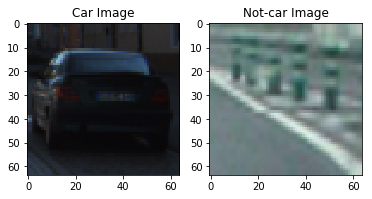

In [2]:
###Load the dataset

cars = glob.glob("vehicles/*/*.*")
notcars = glob.glob("non-vehicles/*/*.*")


print ('# of cars : ' , len(cars))
print ('# of not-cars : ' , len(notcars))

car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Not-car Image')
plt.show()

In [3]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = img.dtype
    # Return data_dict
    return data_dict
print ('OK')

OK


In [4]:
pix_per_cell = 8
cell_per_block = 2
orient = 9
img = car_image
def get_hog_features(img, 
                     orientation=9, 
                     pixels_per_cell=(8,8), 
                     cells_per_block=(2,2), 
                     visualization=False, 
                     feature_vector=True):
    if visualization == True:
        features, hog_image = hog(img, orientations=orientation, 
                                  pixels_per_cell=pixels_per_cell,
                                  cells_per_block=cells_per_block, 
                                  transform_sqrt=False,
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:
        features = hog(img, orientations=orientation, 
                       pixels_per_cell=pixels_per_cell,
                       cells_per_block=cells_per_block, 
                       transform_sqrt=False,
                       visualise=False, feature_vector=feature_vector) 
        return features
print ('OK')

OK


In [8]:
img = car_image
hog_features, hog_image = get_hog_features(img)
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image, cmap='gray')
plt.title('Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Image')
plt.show()

#print (img)

ValueError: The parameter `image` must be a 2-dimensional array

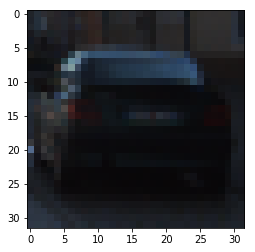

In [9]:
resized_image = cv2.resize(img, (32, 32)) 
plt.imshow(resized_image,cmap='gray')

In [10]:
# Define a function to compute color histogram features
def get_color_histogram(img, nbins=32, bins_range=(0, 256)):
    
    bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    red_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    green_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    blue_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Generating bin centers
    bin_edges = red_hist[1] #all three bins are the same size
    bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges) - 1])/2
    
    hist_features = np.concatenate((red_hist[0],
                                    green_hist[0],
                                    blue_hist[0]))
    
    return red_hist, green_hist, blue_hist, bin_centers, hist_features
    
print ('OK')

OK


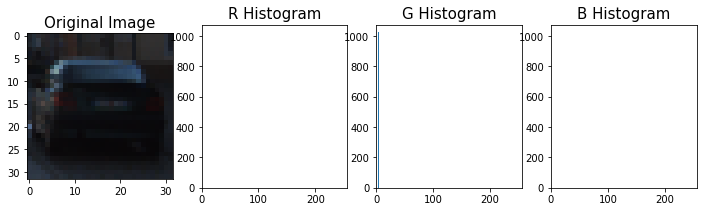

In [17]:
channel1_hist, channel2_hist, channel3_hist, bin_centers, hist_feartures = get_color_histogram(resized_image)
# Plot the examples
fig = plt.figure(figsize=(12,3));

plt.subplot(141)
plt.imshow(resized_image)
plt.title('Original Image', fontsize=15)
plt.subplot(142)
plt.bar(bin_centers, channel1_hist[0])
plt.xlim(0, 256)
plt.title('R Histogram', fontsize=15);
plt.subplot(143)
plt.bar(bin_centers, channel2_hist[0])
plt.xlim(0, 256)
plt.title('G Histogram', fontsize=15);
plt.subplot(144)
plt.bar(bin_centers, channel3_hist[0])
plt.xlim(0, 256)
plt.title('B Histogram', fontsize=15);

In [18]:
def get_bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features
    

In [19]:
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
hist_bins = 32
def extract_features(images, color_space='RGB', 
                     spatial_size=(32,32), 
                     hist_bins=32, hist_range=(0,256),
                     orientations=9, pixels_per_cell=(8,8),
                     cells_per_block=(2,2), hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    features = []
    for file in tqdm(images):
        file_features = []
        img = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(img)      
        
        if spatial_feat == True:
            spatial_features = get_bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            red_hist, green_hist, blue_hist, bin_centers, hist_features = get_color_histogram(feature_image)
            file_features.append(hist_features)
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                                         orientations, pixels_per_cell, 
                                                         cells_per_block, visualization=False,
                                                         feature_vector=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], 
                                                orientations, pixels_per_cell,
                                                cells_per_block, visualization=False,
                                                feature_vector=True)
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))      
    return features

In [20]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 10  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32   # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

veh_features = extract_features(cars, spatial_feat=True, hist_feat=True)
not_veh_features = extract_features(notcars, spatial_feat=True, hist_feat=True)

if len(veh_features) > 0:
    X = np.vstack((veh_features, not_veh_features)).astype(np.float64)
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)
    
    f = plt.figure(figsize=(20, 5))
    matplotlib.rc('xtick', labelsize=30) 
    matplotlib.rc('ytick', labelsize=30)

    plt.subplot(1, 3, 1)
    plt.imshow(mpimg.imread(veh[car_id]))
    plt.title('Original Image:\n', fontsize=30)
    plt.subplot(1, 3, 2)
    plt.plot(X[car_id])
    plt.title('Raw Features:\n', fontsize=30)
    plt.subplot(1, 3, 3)
    plt.plot(scaled_X[car_id])
    plt.title('Normalized Features:\n', fontsize=30)
    plt.savefig('output_images/color_classification.png')

else:
    print('Returned empty feature vectors.')

100%|██████████| 8968/8968 [01:12<00:00, 124.66it/s]


NameError: name 'matplotlib' is not defined

In [21]:
X = np.vstack((veh_features, not_veh_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(veh_features)), np.zeros(len(not_veh_features))))

print (scaled_X.shape)
print (y.shape)

MemoryError: 

In [ ]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y,
                                                    test_size=0.2,
                                                    random_state=rand_state)
# Use a linear SVC
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'seconds to train SVC.')
print('Using:', orient, 'orientations', pix_per_cell,
    'pixels per cell and', cell_per_block, 'cells per block')
print('Feature vector length:', len(X_train[0]))